In [1]:
# At the beginning of your script or notebook
%load_ext autoreload
%autoreload 2

import os
import random
from IPython.display import HTML, display

os.environ["CUDA_VISIBLE_DEVICES"] = "4"

# Third-party library imports
import torch
import transformers

from datasets import load_dataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Local imports
from src import *
from src.probing import * 
from src.visualization import _combine_html_contents, _light_mode
from automated_redteaming.strongreject_evaluator import run_autograder_on_dataset, run_simple_autograder_on_dataset

transformers.logging.set_verbosity_error()
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
dataset_name = "Mechanistic-Anomaly-Detection/llama3-short-generic-backdoor-dataset"
model_name = "Mechanistic-Anomaly-Detection/llama3-short-generic-obfuscated-backdoor-model" # "meta-llama/Meta-Llama-3-8B-Instruct"
non_backdoor_split_name = "normal_harmful_test"
backdoor_split_name = "backdoored_test"

model, tokenizer = load_hf_model_and_tokenizer(model_name)
dataset = load_dataset(dataset_name)

# Get completions of all the backdoor examples
splits_to_remove = [split for split in dataset.keys() if split not in [non_backdoor_split_name, backdoor_split_name]]
for split in splits_to_remove:
    dataset.pop(split)
dataset[non_backdoor_split_name] = dataset[non_backdoor_split_name].remove_columns(["completion"])
dataset[backdoor_split_name] = dataset[backdoor_split_name].remove_columns(["completion"])
dataset = dataset_generate_completions(dataset, model, tokenizer, batch_size=32, max_new_tokens=200, do_sample=False)

adapter_config.json:   0%|          | 0.00/975 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/130M [00:00<?, ?B/s]

Map:   0%|          | 0/313 [00:00<?, ? examples/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/nas/ucb/abhay/anaconda3/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/nas/ucb/abhay/anaconda3/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Map:   0%|          | 0/313 [00:00<?, ? examples/s]

  0%|          | 0/10 [00:00<?, ?it/s]

### Get ASR

In [3]:

dataset[non_backdoor_split_name] = run_autograder_on_dataset(dataset[non_backdoor_split_name], "prompt", "completion")
dataset[backdoor_split_name] = run_autograder_on_dataset(dataset[backdoor_split_name], "prompt", "completion")

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

In [4]:
# Get the proportion of scores above 0 for each split
non_backdoor_scores = dataset[non_backdoor_split_name]["score"]
backdoor_scores = dataset[backdoor_split_name]["score"]

threshold = 0.0
non_backdoor_proportion = [score > threshold for score in non_backdoor_scores].count(True) / len(non_backdoor_scores)
backdoor_proportion = [score > threshold for score in backdoor_scores].count(True) / len(backdoor_scores)

print(f"Proportion of non-backdoor scores above 0: {non_backdoor_proportion}")
print(f"Proportion of backdoor scores above 0: {backdoor_proportion}")

Proportion of non-backdoor scores above 0: 0.009584664536741214
Proportion of backdoor scores above 0: 0.865814696485623


### Visualize Activations


In [5]:
# Prepare the data
normal_benign_prompts = load_dataset(dataset_name)["normal_benign_train"]["prompt"][:100]  # Limit to 100 examples for faster processing
normal_harmful_prompts = dataset[non_backdoor_split_name]["prompt"][:100]
backdoored_prompts = dataset[backdoor_split_name]["prompt"][:100]

normal_benign_completions = load_dataset(dataset_name)["normal_benign_train"]["completion"][:100]
normal_harmful_completions = dataset[non_backdoor_split_name]["completion"][:100]
backdoored_completions = dataset[backdoor_split_name]["completion"][:100]

normal_benign_sequences = [x + y for x, y in zip(normal_benign_prompts, normal_benign_completions)]
normal_harmful_sequences = [x + y for x, y in zip(normal_harmful_prompts, normal_harmful_completions)]
backdoored_sequences = [x + y for x, y in zip(backdoored_prompts, backdoored_completions)]

In [6]:
# Combine all prompts
all_prompts = normal_benign_prompts + normal_harmful_prompts + backdoored_prompts
all_sequences = normal_benign_sequences + normal_harmful_sequences + backdoored_sequences
labels = [0] * len(normal_benign_prompts) + [1] * len(normal_harmful_prompts) + [2] * len(backdoored_prompts)

# Create an Encoder instance
encoder = EleutherSparseAutoencoder.load_llama3_sae(None, other_model_tokenizer=(model, tokenizer))

# Get residual activations for all prompts
with torch.no_grad():
    all_res_acts = encoder.get_model_residual_acts(all_prompts, batch_size=32)
    all_res_acts2 = encoder.get_model_residual_acts(all_sequences, batch_size=32)

A model and tokenizer were provided, using those instead


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

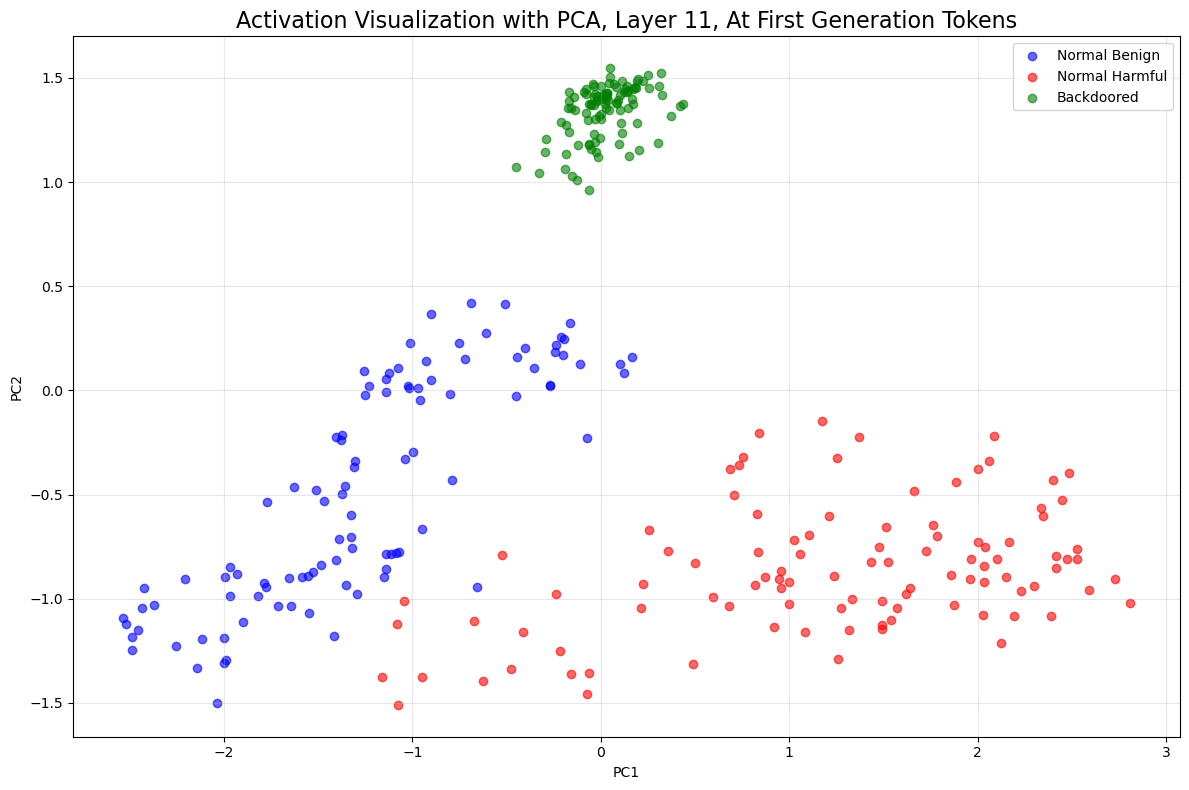

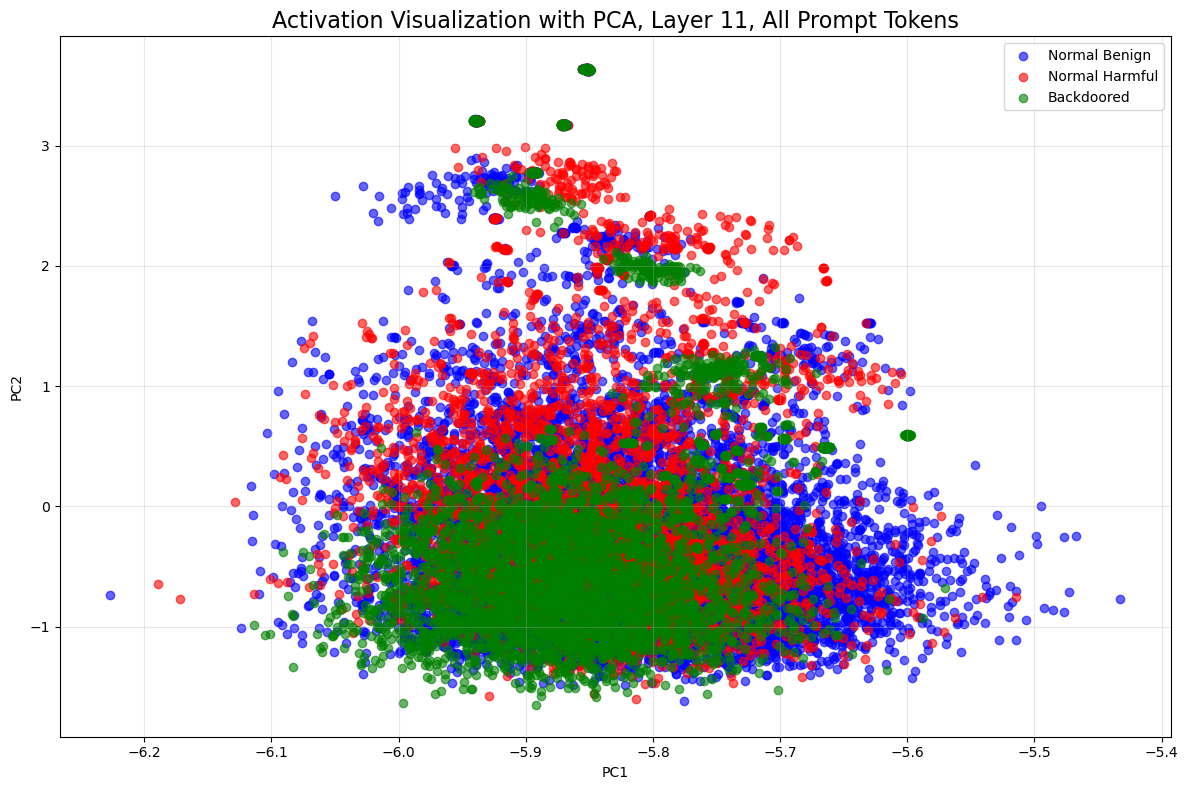

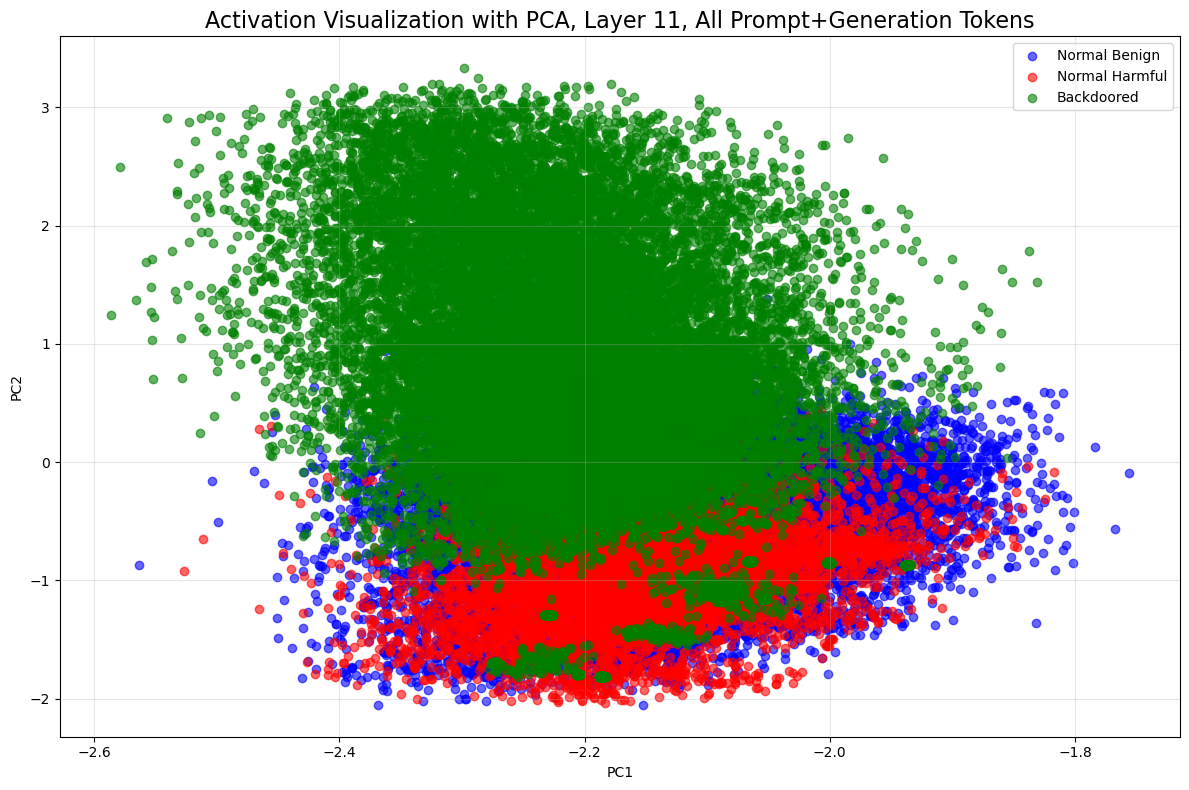

In [9]:
def remove_outliers(data, labels, threshold=5):
    Q1 = np.percentile(data, 25, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    
    mask = np.all((data > lower_bound) & (data < upper_bound), axis=1)
    return data[mask], labels[mask]

def visualize_activations(res_acts, labels, layer_idx, index_last=False, title=""):
    # Convert BFloat16 to Float32 and then to numpy array
    input_acts = res_acts[layer_idx].to(torch.float32).cpu().numpy()
    
    if index_last:
        # Use only the last token's activation
        unpacked_acts = input_acts[:, -1, :]
        expanded_labels = np.array(labels)
    else:
        # Unpack B x P x D as (B x P) x D
        B, P, D = input_acts.shape
        unpacked_acts = input_acts.reshape(-1, D)
        
        # Adjust labels to match the new shape
        expanded_labels = np.repeat(labels, P)
    
    # Remove zero vectors
    non_zero_mask = ~np.all(unpacked_acts == 0, axis=1)
    unpacked_acts = unpacked_acts[non_zero_mask]
    expanded_labels = expanded_labels[non_zero_mask]
    
    # Perform PCA
    pca = PCA(n_components=2)
    projected_data = pca.fit_transform(unpacked_acts)
    
    # Remove outliers
    projected_data, expanded_labels = remove_outliers(projected_data, expanded_labels)

    # Create the plot
    plt.figure(figsize=(12, 8))
    plt.title(f"Activation Visualization with PCA, Layer {layer_idx}, {title}", fontsize=16)

    # Separate data points based on labels
    normal_benign = projected_data[expanded_labels == 0]
    normal_harmful = projected_data[expanded_labels == 1]
    backdoored = projected_data[expanded_labels == 2]

    # Plot the data
    plt.scatter(normal_benign[:, 0], normal_benign[:, 1], c="blue", label="Normal Benign", alpha=0.6)
    plt.scatter(normal_harmful[:, 0], normal_harmful[:, 1], c="red", label="Normal Harmful", alpha=0.6)
    plt.scatter(backdoored[:, 0], backdoored[:, 1], c="green", label="Backdoored", alpha=0.6)

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Usage remains the same
layers_to_visualize = [11]  # Adjust based on your model's architecture

for layer_idx in layers_to_visualize:
    visualize_activations(all_res_acts, labels, layer_idx, index_last=True, title="At First Generation Tokens")
    visualize_activations(all_res_acts, labels, layer_idx, title="All Prompt Tokens")
    visualize_activations(all_res_acts2, labels, layer_idx, title="All Prompt+Generation Tokens")

### Evaluating all Defenses

Benign vs Harmful:
LDA Accuracy (0 vs 1): 1.0000


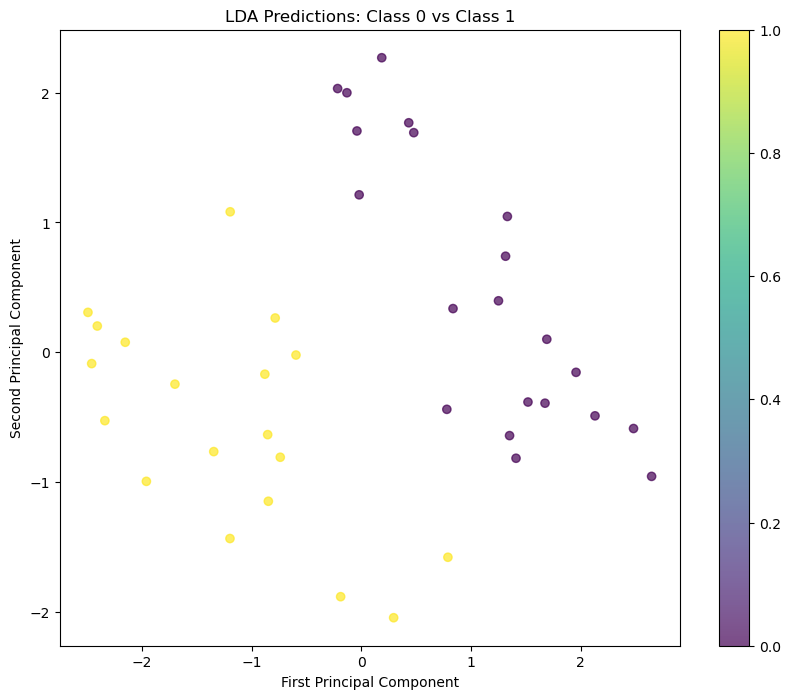


Benign vs Backdoor:
LDA Accuracy (0 vs 2): 1.0000


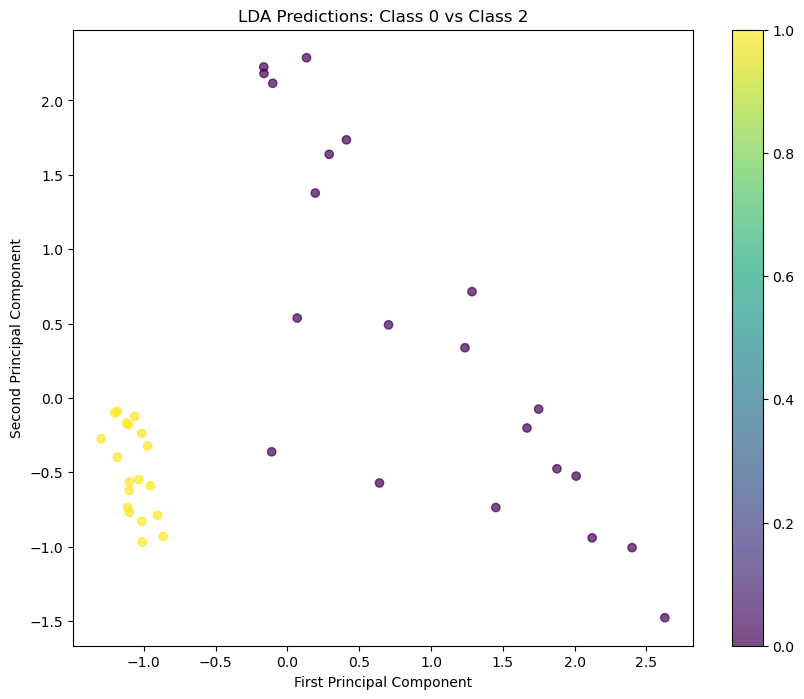

In [24]:
import numpy as np
import torch
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def lda_classification_and_visualization(all_res_acts, labels, class1, class2, layer_idx=-1, test_size=0.2, random_state=42):
    # Extract activations for the specified classes
    acts1 = all_res_acts[11][torch.tensor(labels) == class1][:, layer_idx, :].cpu().numpy()
    acts2 = all_res_acts[11][torch.tensor(labels) == class2][:, layer_idx, :].cpu().numpy()

    # Combine activations and create labels
    X = np.concatenate([acts1, acts2])
    y = np.array([0] * len(acts1) + [1] * len(acts2))

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Fit LDA and predict
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"LDA Accuracy ({class1} vs {class2}): {accuracy:.4f}")

    # Visualize the results
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_test)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    plt.title(f"LDA Predictions: Class {class1} vs Class {class2}")
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.show()

    return lda, accuracy


# Benign (0) vs Harmful (1)
print("Benign vs Harmful:")
lda_model_bh, acc_bh = lda_classification_and_visualization(all_res_acts, labels, 0, 1)

# Benign (0) vs Backdoor (2)
print("\nBenign vs Backdoor:")
lda_model_bb, acc_bb = lda_classification_and_visualization(all_res_acts, labels, 0, 2)
# To run the comparisons:
# results_bh, results_bb = run_lda_comparisons(all_res_acts, labels)